In [1]:
#Uses debiased sinkhorn method to compare random PAIRS of images
#to visualize and determine robustness to noise

import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import ot
import os
import warnings
import sys
import sinkhorn_barycenters as sink
from itertools import combinations

#set variables
n = 3 #choosing how many datasets to use (noise, no noise) for one barycenter
epsilon = .2 #will optimize this later
max_iterations = int(1e6) #will optimize this later
width = 50
rng = np.random.RandomState(42)#42

In [2]:
#function to choose n random artificial datasets
def find_index(n):
    index = rng.choice(np.arange(200), size=(n), replace=False)
    index.sort()
    return index

#returing variables
index = find_index(n)

In [40]:
#load datasets, this function takes the random indexes and loads n pairs of artificial data with and without noise
def load_data(num_pairs, index):
    noise = []
    nonoise = []
    for i in range(len(index)):
        noise.append(abs(np.load("./artificial_data.npy")[index[i], :, :]))
        nonoise.append(np.load("./artificial_data_no_noise.npy")[index[i], :, :])
    return np.asarray(noise), np.asarray(nonoise)
        

#returning variables
noise, nonoise = load_data(n,index) 

In [41]:
#formatting function
def debiased_format(dataset, epsilon):
    P = torch.from_numpy(dataset)    
    grid = torch.arange(width).type(torch.float64)
    grid /= width
    M = (grid[:, None] - grid[None, :]) ** 2
    K = torch.exp(- M / epsilon)
    #K = torch.from_numpy(K)
    return P, K

#creating variables for debiased algo
P_nonoise, K_nonoise = debiased_format(nonoise, epsilon)
P_noise, K_noise = debiased_format(noise, epsilon)


In [42]:
print(P_noise)

tensor([[[6.5973e-02, 1.8719e-01, 1.4802e-01,  ..., 1.1868e-01,
          6.6172e-02, 6.1925e-02],
         [1.5372e-01, 1.9046e-01, 7.0583e-02,  ..., 2.7640e-02,
          1.2176e-02, 6.4757e-02],
         [1.0717e-01, 6.5578e-02, 2.2273e-01,  ..., 2.5751e-02,
          7.0427e-02, 9.5590e-02],
         ...,
         [6.5839e-02, 3.3335e-02, 3.9932e-02,  ..., 9.3424e-02,
          2.4410e-01, 4.7645e-03],
         [9.8129e-03, 1.2107e-01, 5.1786e-02,  ..., 5.4998e-02,
          1.6786e-02, 2.5311e-02],
         [1.3334e-01, 1.5809e-01, 6.8761e-02,  ..., 1.9260e-02,
          4.4917e-02, 6.5883e-02]],

        [[3.9960e-02, 1.6421e-01, 8.3091e-03,  ..., 2.0478e-02,
          7.3889e-02, 1.1546e-01],
         [7.9505e-02, 4.0041e-02, 6.7792e-02,  ..., 1.7357e-01,
          2.3444e-05, 1.3494e-01],
         [1.1463e-01, 7.9913e-02, 4.6754e-03,  ..., 9.1784e-03,
          5.8301e-02, 2.5026e-02],
         ...,
         [6.0241e-02, 2.2149e-01, 9.9053e-02,  ..., 2.5155e-01,
          1.502

In [43]:
##Runs sinkhorn algorithm for multiple data sets within noise and no noise respectively
def run_sinkhorn_mult(P_noise, K_noise, P_nonoise, K_nonoise, max_iterations):
    qnonoise = sink.barycenter(P_nonoise, K_nonoise, reference="debiased", maxiter = max_iterations)
    qnoise = sink.barycenter(P_noise, K_noise, reference="debiased", maxiter = max_iterations)
    return qnonoise, qnoise


q_nonoise_mult, q_noise_mult = run_sinkhorn_mult(P_noise, K_noise, P_nonoise, K_nonoise, max_iterations)

KeyboardInterrupt: 

In [37]:
print(q_noise_mult)
print(index)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)
[15 30 95]


In [8]:
np.save("./index_mult3.npy", index_mult)
np.save("./q_nonoise_mult3.npy", q_nonoise_mult)           
np.save("./q_noise_mult3.npy", q_noise_mult)

In [4]:
#plotting results for barycenters with multiple datasets per barycenter
q_nonoise_mult = np.load('./q_nonoise_mult3.npy')
q_noise_mult = np.load('./q_noise_mult3.npy')
index_mult = np.load('./index_mult3.npy')

In [12]:
#function to plot just the barycenter for multiple datasets at once
def plot_compare_mult(q_noise, q_nonoise):
    m=1
    for i in range(0,len(q_nonoise)): #change back to len(q_noise) for the def
        plt.figure(1, figsize=(10,100))
        plt.subplot(len(q_nonoise),2,i+m)
        plt.imshow(q_nonoise[i]) #change back to q_nonoise for the def
        plt.title(f"No Noise \n max iterations: {int(parameters[i][0])} and epsilon: {parameters[i][1]}")
        plt.axis("off")

        plt.subplot(len(q_noise),2,i+m+1)
        plt.imshow(q_noise[i]) #change back to q_noise for the def
        plt.title(f"Noise \n max iterations: {int(parameters[i][0])} and epsilon: {parameters[i][1]}")
        plt.axis("off")
        m+=1

In [14]:
print(q_nonoise_mult[0])

[3.02734901e-54 3.25078337e-52 2.93123757e-50 2.22306036e-48
 1.42025615e-46 7.65514122e-45 3.48613816e-43 1.34323591e-41
 4.38495687e-40 1.21436759e-38 2.85660786e-37 5.71462527e-36
 9.73329186e-35 1.41299891e-33 1.75019399e-32 1.85149223e-31
 1.67438297e-30 1.29558963e-29 8.58458060e-29 4.87467197e-28
 2.37387920e-27 9.92081466e-27 3.56021694e-26 1.09770872e-25
 2.90935383e-25 6.63129033e-25 1.30035180e-24 2.19447234e-24
 3.18806132e-24 3.98792590e-24 4.29599227e-24 3.98587369e-24
 3.18529926e-24 2.19251201e-24 1.29978749e-24 6.63575175e-25
 2.91688419e-25 1.10371879e-25 3.59403069e-26 1.00678809e-26
 2.42521960e-27 5.02133779e-28 8.93134199e-29 1.36392769e-29
 1.78717327e-30 2.00789468e-31 1.93280218e-32 1.59277480e-33
 1.12270388e-34 6.76267531e-36]


TypeError: Invalid shape (50,) for image data

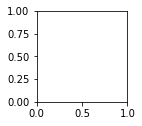

In [13]:
plot_compare_mult(q_noise_mult, q_nonoise_mult) 

In [21]:
i = [15,95]
noise = abs(np.load("./artificial_data.npy")[i])

In [22]:
noise.shape

(2, 50, 50)